### Credit: https://colab.research.google.com/drive/1246XGJbtbqQ4pb86tGk64hZAF3_bV6hM?usp=sharing


In [1]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl

random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

print(f'Number of GPUs: {AVAIL_GPUS}')

Number of GPUs: 1


In [2]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", 
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [3]:
## Torch nn.Module Approach
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)
  
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [4]:
## Torch nn.Module Approach
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]
    

    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256
        
        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)
        
        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)
        
        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

In [5]:
## PyTorch Lightning Approach
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002, 
                 b1=0.5, b2=0.999, batch_size=128):
        super().__init__()
        self.save_hyperparameters()

        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()

        self.validation_z = torch.randn(8, self.hparams.latent_dim)

        # Disable automatic optimization
        self.automatic_optimization = False

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx):
        real_imgs, _ = batch

        # sample noise
        z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim, device=self.device)

        # Get optimizers
        opt_g, opt_d = self.optimizers()

        # -----------------
        # Train generator
        # -----------------
        self.generated_imgs = self(z)
        predictions = self.discriminator(self.generated_imgs)
        g_loss = self.adversarial_loss(predictions, torch.ones(real_imgs.size(0), 1, device=self.device))

        # Backpropagate and optimize generator
        opt_g.zero_grad()
        self.manual_backward(g_loss)
        opt_g.step()

        # Log generator loss
        self.log('g_loss', g_loss, prog_bar=True)

        # ---------------------
        # Train discriminator
        # ---------------------
        real_preds = self.discriminator(real_imgs)
        real_loss = self.adversarial_loss(real_preds, torch.ones(real_imgs.size(0), 1, device=self.device))

        fake_preds = self.discriminator(self(z).detach())
        fake_loss = self.adversarial_loss(fake_preds, torch.zeros(real_imgs.size(0), 1, device=self.device))

        d_loss = (real_loss + fake_loss) / 2

        # Backpropagate and optimize discriminator
        opt_d.zero_grad()
        self.manual_backward(d_loss)
        opt_d.step()

        # Log discriminator loss
        self.log('d_loss', d_loss, prog_bar=True)

    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d]

    def plot_images(self):
        z = self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).cpu()
        
        print('epoch:', self.current_epoch)
        
        # Adjust the figure size based on the grid (2 rows, 4 columns)
        fig = plt.figure(figsize=(8, 4))  # Adjust the width and height according to the grid

        for i in range(len(sample_imgs)):
            plt.subplot(2, 4, i + 1)  # 2 rows and 4 columns for up to 8 images
            
            plt.imshow(sample_imgs[i].detach().numpy().reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')

        # Call tight_layout after all subplots have been added
        plt.tight_layout()
        plt.show()

    def on_epoch_end(self):
        self.plot_images()
        # Log sampled images
        sample_imgs = self(self.validation_z)
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image("generated_images", grid, self.current_epoch)

In [6]:
trainer = pl.Trainer(max_epochs=20)

dm = MNISTDataModule()
model = GAN()
trainer.fit(model, dm)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/gojian/Programs/Mamba/envs/awg/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA RTX 5000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 358 K  | train
1 | discriminator | Discriminator | 21.4 K | train
--------------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 430/430 [00:02<00:00, 162.00it/s, v_num=14, g_loss=1.330, d_loss=0.470]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 430/430 [00:02<00:00, 160.43it/s, v_num=14, g_loss=1.330, d_loss=0.470]


epoch: 20


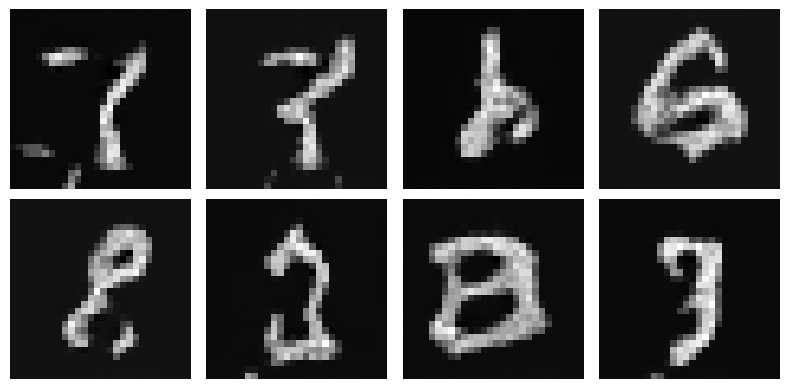

In [7]:
model.plot_images()